In [1]:
import os
import pandas as pd
from popstudies_preprocessor import build_datasets, load_curated
from popstudies_analysis import (make_word_vis, make_author_table,
                                 make_affil_plot,
                                 summarize_scrape_and_curate,
                                 gender_over_time, headline_topics,
                                 make_mwc, make_mf_topics)
%load_ext autoreload
%autoreload 2
d_path = os.path.abspath(os.path.join('..', 'data'))
figure_path = os.path.abspath(os.path.join('..', 'article',
                                           'figures'))
main_df, ref_df, auth_df = build_datasets(d_path)

In [2]:
summarize_scrape_and_curate(main_df, auth_df, ref_df, d_path)

Total number of papers in our database: 1901
Papers with no abstract: 182
There are 1858 Articles.
There are 5 Editorials.
There are 19 Erratums.
There are 2 Letters.
There are 6 Notes.
There are 11 Reviews.
Average number of authors per paper: 1.2335612835349816
Average number of references per paper: 24.76801683324566
Date of first article: 1947-01-01
Date of most recent article: 2020-09-01
Average paper length (pages): 15.44390243902439
Number of OpenAccess articles: 52


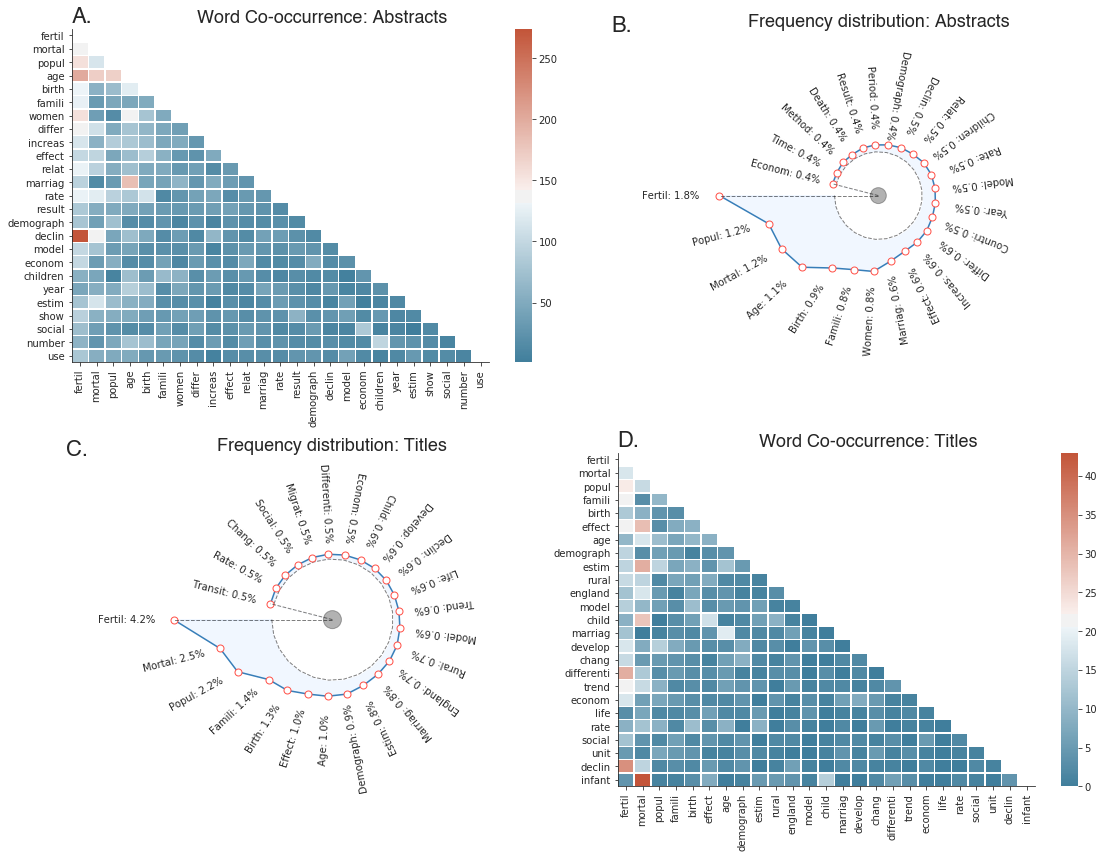

In [3]:
make_word_vis(main_df, figure_path, d_path)

In [4]:
make_author_table(auth_df, main_df, d_path, 'Papers')

                     Papers  Cites  H-Index First  Last
fullname                                               
Samuel H. Preston        12   1135        9  1974  2016
Ronald F. Freedman       11    213        8  1954  1990
John E. Knodel           11    492        8  1967  2000
Robert G. Potter         10    142        6  1956  1969
John P.M. Bongaarts      10    335        8  1976  2019


In [5]:
make_author_table(auth_df, main_df, d_path, 'Cites')

                   Papers  Cites  H-Index First  Last
fullname                                             
Samuel H. Preston      12   1135        9  1974  2016
Larry L. Bumpass        4    784        3  1986  2000
Hsien Hen Lu            1    732        1  2000  2000
John G.F. Cleland       6    686        6  1987  2003
Thomas McKeown          6    649        5  1955  1978


In [6]:
make_author_table(auth_df, main_df, d_path, 'H-Index')

                     Papers  Cites  H-Index First  Last
fullname                                               
Samuel H. Preston        12   1135        9  1974  2016
Ronald F. Freedman       11    213        8  1954  1990
John E. Knodel           11    492        8  1967  2000
John P.M. Bongaarts      10    335        8  1976  2019
Gigi Santow               9    358        7  1979  1998


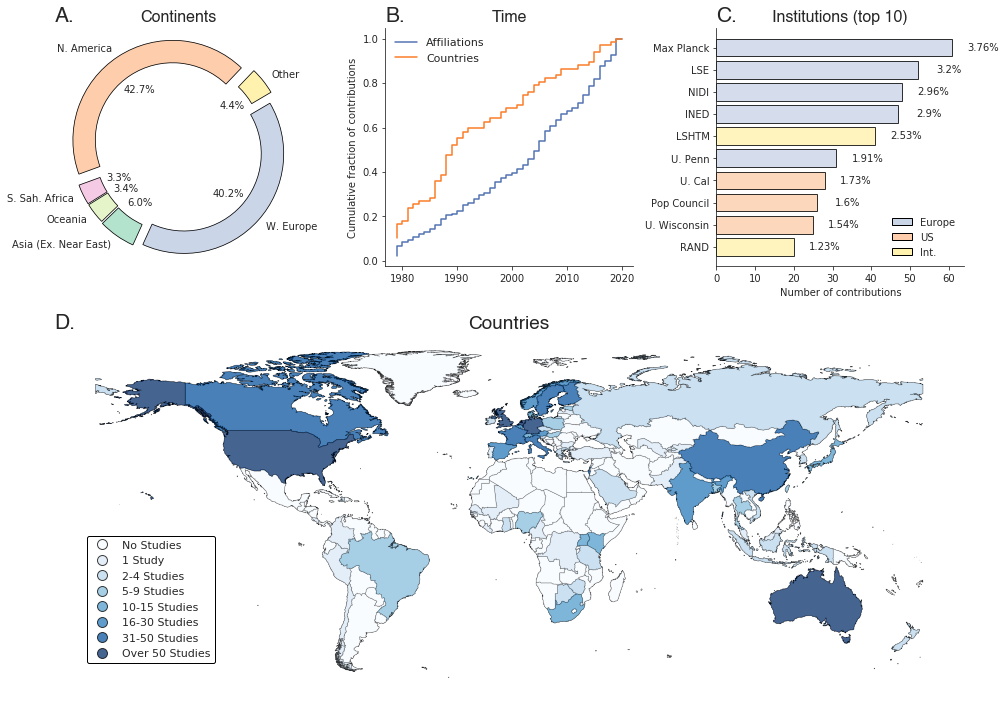

In [7]:
make_affil_plot(main_df, auth_df, d_path, figure_path)

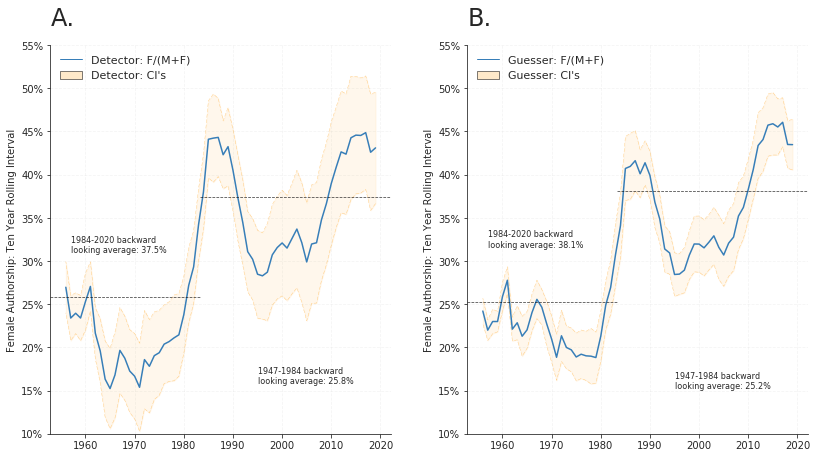

In [8]:
gender_over_time(auth_df)

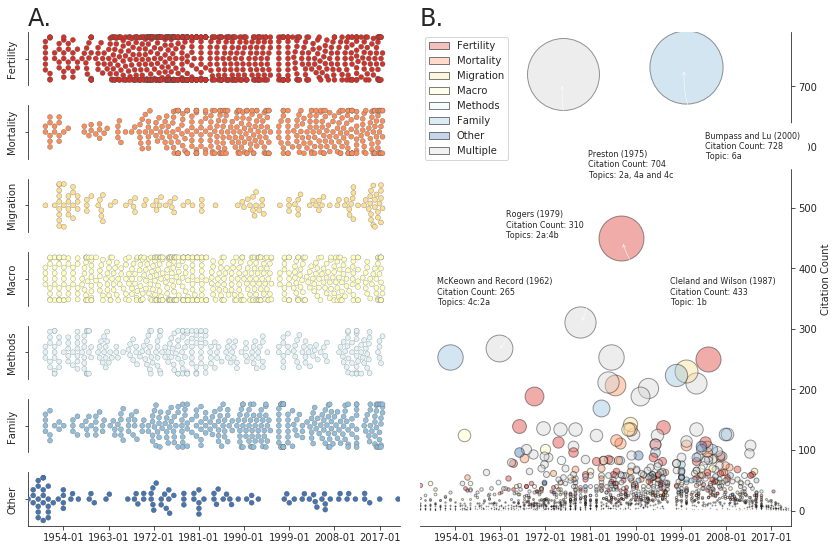

In [9]:
headline_topics(main_df)

In [10]:
main_df[main_df['Nation'].notnull()].groupby(['Nation'])['Nation'].count().sort_values(ascending=False)

Nation
United States                      108
China                               79
England; Wales                      61
India                               60
United Kingdom                      54
                                  ... 
Hungary; Sweden                      1
Taiwan; South Korea; Bangladesh      1
Holland                              1
Tibet; China                         1
Finland; Norway                      1
Name: Nation, Length: 277, dtype: int64

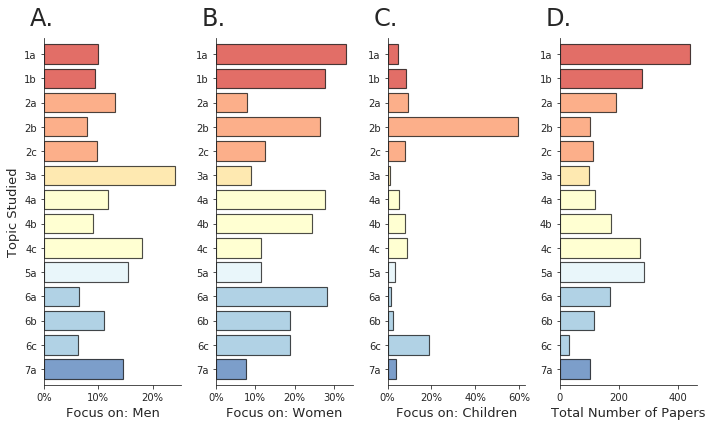

In [11]:
make_mwc(main_df)

In [12]:
make_mf_topics(auth_df, main_df, d_path)

   Topic_M Subtopics_M Topic_F Subtopics_F Topic_Ratio Subtopics_Ratio
1a     539         305     266         188        2.03            1.62
1b                 234                  78                         3.0
2a     344         159     207          72        1.66            2.21
2b                  76                  49                        1.55
2c                 109                  86                        1.27
3a      97          77      60          49        1.62            1.57
3b                   6                   4                         1.5
3c                  14                   7                         2.0
4a     399          90     203          57        1.97            1.58
4b                 136                  89                        1.53
4c                 173                  57                        3.04
5a     219         219      65          65        3.37            3.37
6a     225         118     191          83        1.18            1.42
6b    